🚀 Initializing Policy Gap Detector...
📱 Using device: cpu
🤖 Loading model: facebook/bart-large-mnli
✅ Model loaded successfully!

📂 Loading data from pairs.csv...
✅ Loaded 100 claim-report pairs
📊 Columns: ['id', 'scheme_name', 'claim_text', 'report_text', 'synthetic_gold_label', 'claim_length', 'report_length']

🔍 Running NLI predictions on 100 pairs...


Processing: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.82s/it]


✅ Predictions complete!

📊 Generating visualizations...


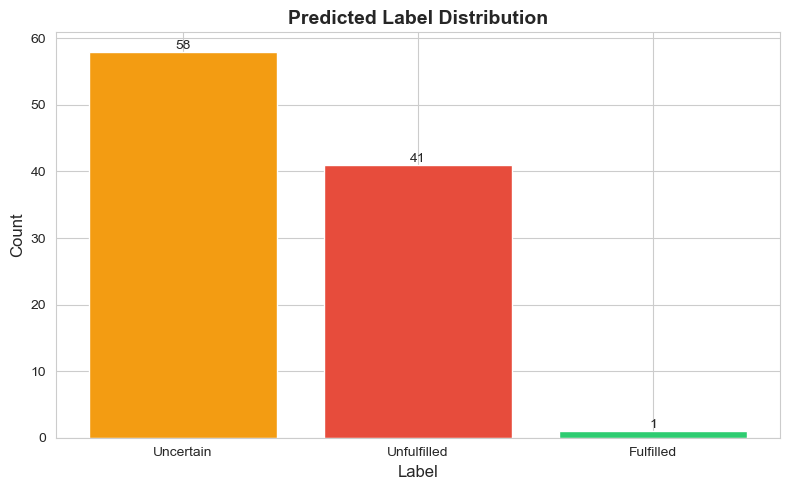

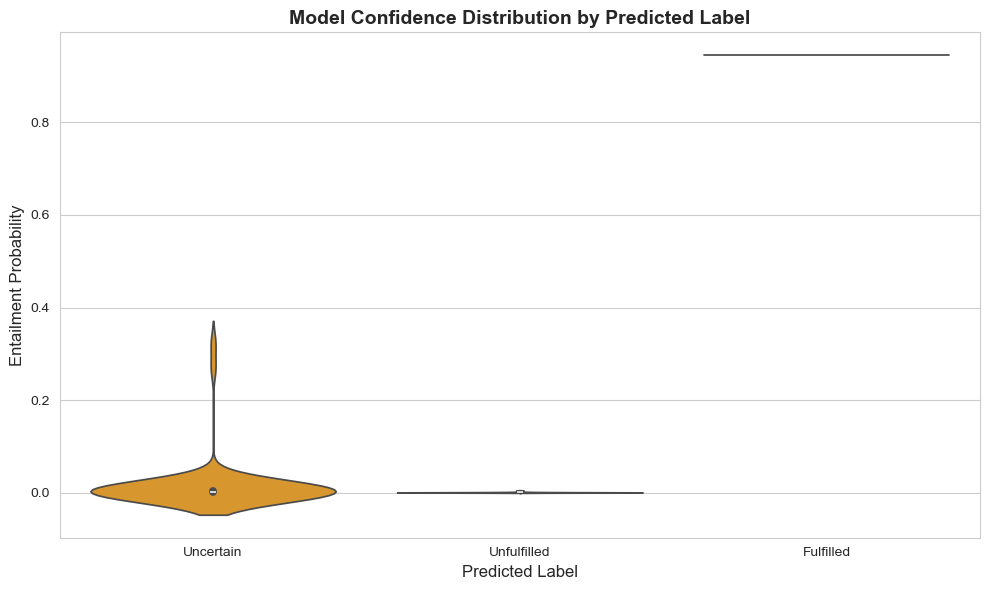

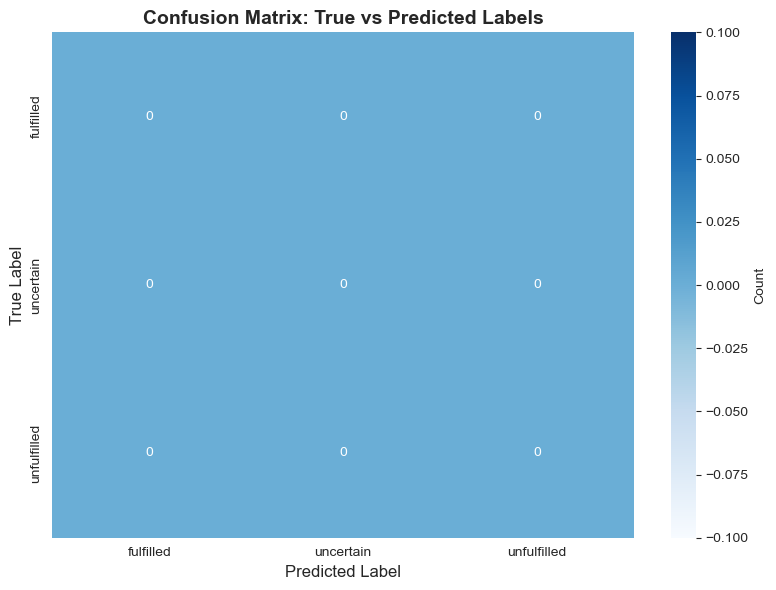


📈 Classification Report:
              precision    recall  f1-score   support

   Fulfilled       0.00      0.00      0.00       0.0
   Uncertain       0.00      0.00      0.00       0.0
 Unfulfilled       0.00      0.00      0.00       0.0
   fulfilled       0.00      0.00      0.00      40.0
   uncertain       0.00      0.00      0.00      20.0
 unfulfilled       0.00      0.00      0.00      40.0

    accuracy                           0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0



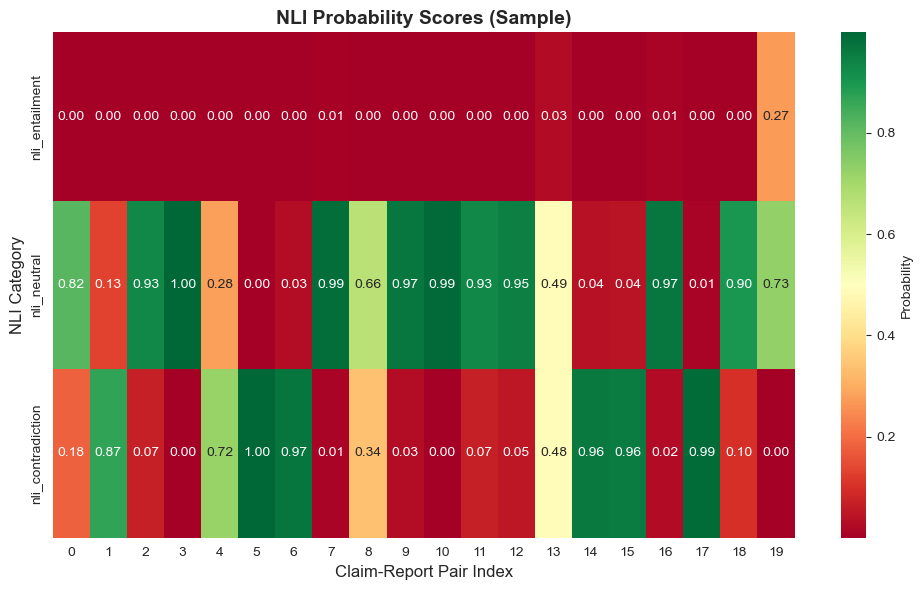

✅ Visualizations saved to 'visualizations/' directory


📊 POLICY GAP DETECTION REPORT

📋 Dataset Overview:
   Total Claims Analyzed: 100

🎯 Predictions Summary:
   Fulfilled   :    1 (  1.0%)
   Unfulfilled :   41 ( 41.0%)
   Uncertain   :   58 ( 58.0%)

🔍 Confidence Metrics:
   Average Confidence: 0.894
   High Confidence (>0.8): 81 (81.0%)
   Low Confidence (<0.5): 1 (1.0%)

📏 Text Statistics:
   Avg Claim Length: 19.0 words
   Avg Report Length: 26.9 words


🔎 Sample Predictions (Top 5):

--- Pair 1 ---
Claim: Jal Jeevan Mission has successfully provided households in cluster of habitations of Punjab with ele...
Report: Media fact-checks reveal that toilets built under the program are not functional or lack water and m...
Prediction: Uncertain (Confidence: 0.817)

--- Pair 2 ---
Claim: Ujjwala Yojana reports that roads connecting habitations in district, Tamil Nadu are complete and mo...
Report: On-ground checks show that toilets were constructed in the majority of households in tar

In [8]:
"""
AI-Powered Policy vs Practice Gap Detection System
===================================================
Detects discrepancies between government claims and ground reality reports
using Natural Language Inference (NLI) models.

Author: [Your Name]
Date: October 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

class PolicyGapDetector:
    """Main class for detecting policy-practice gaps using NLI"""
    
    def __init__(self, model_name="facebook/bart-large-mnli"):
        """Initialize the detector with specified NLI model"""
        print("🚀 Initializing Policy Gap Detector...")
        self.model_name = model_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"📱 Using device: {self.device}")
        
        # Load model and tokenizer
        print(f"🤖 Loading model: {model_name}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        
        # Label mappings
        self.LABEL_MAP = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}
        print("✅ Model loaded successfully!\n")
    
    def load_data(self, pairs_path):
        """Load and preprocess the claim-report pairs"""
        print(f"📂 Loading data from {pairs_path}...")
        try:
            pairs = pd.read_csv(pairs_path)
            
            # Ensure text columns are strings
            pairs['claim_text'] = pairs['claim_text'].astype(str)
            pairs['report_text'] = pairs['report_text'].astype(str)
            
            # Add explainable features
            pairs['claim_length'] = pairs['claim_text'].apply(lambda x: len(x.split()))
            pairs['report_length'] = pairs['report_text'].apply(lambda x: len(x.split()))
            
            print(f"✅ Loaded {len(pairs)} claim-report pairs")
            print(f"📊 Columns: {list(pairs.columns)}\n")
            return pairs
            
        except FileNotFoundError:
            print(f"❌ Error: File '{pairs_path}' not found!")
            return None
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            return None
    
    def predict_nli(self, premises, hypotheses, batch_size=8, max_length=512):
        """
        Predict NLI scores for premise-hypothesis pairs
        
        Args:
            premises: List of ground reality reports (context)
            hypotheses: List of government claims (statements to verify)
            batch_size: Number of pairs to process at once
            max_length: Maximum token length for model input
        
        Returns:
            List of dictionaries with NLI probabilities
        """
        print(f"🔍 Running NLI predictions on {len(premises)} pairs...")
        results = []
        
        # Process in batches with progress bar
        for i in tqdm(range(0, len(premises), batch_size), desc="Processing"):
            batch_prem = premises[i:i+batch_size]
            batch_hyp = hypotheses[i:i+batch_size]
            
            # Tokenize
            enc = self.tokenizer(
                batch_prem, 
                batch_hyp, 
                return_tensors='pt', 
                padding=True, 
                truncation=True, 
                max_length=max_length
            )
            enc = {k: v.to(self.device) for k, v in enc.items()}
            
            # Get predictions
            with torch.no_grad():
                out = self.model(**enc)
                probs = torch.softmax(out.logits, dim=-1).cpu().numpy()
            
            # Store results
            for p in probs:
                d = {self.LABEL_MAP[j]: float(p[j]) for j in range(len(p))}
                results.append(d)
        
        print("✅ Predictions complete!\n")
        return results
    
    def assign_labels(self, df, entail_thresh=0.7, contra_thresh=0.7):
        """
        Assign final labels based on NLI probabilities
        
        Decision Logic:
        - If entailment >= threshold → Fulfilled
        - If contradiction >= threshold → Unfulfilled
        - Otherwise → Uncertain
        """
        def classify(row):
            if row['nli_entailment'] >= entail_thresh:
                return 'Fulfilled'
            elif row['nli_contradiction'] >= contra_thresh:
                return 'Unfulfilled'
            else:
                return 'Uncertain'
        
        df['predicted_label'] = df.apply(classify, axis=1)
        
        # Add confidence score (max probability)
        df['confidence'] = df[['nli_entailment', 'nli_neutral', 'nli_contradiction']].max(axis=1)
        
        return df
    
    def visualize_results(self, df, save_dir="visualizations"):
        """Generate comprehensive visualizations"""
        import os
        os.makedirs(save_dir, exist_ok=True)
        
        print("📊 Generating visualizations...")
        
        # 1. Predicted Label Distribution
        plt.figure(figsize=(8, 5))
        counts = df['predicted_label'].value_counts()
        colors = {'Fulfilled': '#2ecc71', 'Unfulfilled': '#e74c3c', 'Uncertain': '#f39c12'}
        bars = plt.bar(counts.index, counts.values, color=[colors.get(x, '#95a5a6') for x in counts.index])
        plt.title('Predicted Label Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Label', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        
        # Add count labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f"{save_dir}/label_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # 2. Confidence Distribution by Label
        plt.figure(figsize=(10, 6))
        sns.violinplot(data=df, x='predicted_label', y='nli_entailment', 
                      palette=colors, hue='predicted_label', legend=False)
        plt.title('Model Confidence Distribution by Predicted Label', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('Entailment Probability', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/confidence_distribution.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # 3. Confusion Matrix (if ground truth available)
        if 'synthetic_gold_label' in df.columns or 'true_label' in df.columns:
            true_col = 'synthetic_gold_label' if 'synthetic_gold_label' in df.columns else 'true_label'
            
            plt.figure(figsize=(8, 6))
            labels = sorted(df[true_col].unique())
            cm = confusion_matrix(df[true_col], df['predicted_label'], labels=labels)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
            plt.title('Confusion Matrix: True vs Predicted Labels', fontsize=14, fontweight='bold')
            plt.xlabel('Predicted Label', fontsize=12)
            plt.ylabel('True Label', fontsize=12)
            plt.tight_layout()
            plt.savefig(f"{save_dir}/confusion_matrix.png", dpi=300, bbox_inches='tight')
            plt.show()
            
            # Print classification report
            print("\n📈 Classification Report:")
            print(classification_report(df[true_col], df['predicted_label']))
        
        # 4. NLI Score Heatmap (sample)
        plt.figure(figsize=(10, 6))
        sample = df[['nli_entailment', 'nli_neutral', 'nli_contradiction']].head(20)
        sns.heatmap(sample.T, cmap='RdYlGn', annot=True, fmt='.2f', 
                   cbar_kws={'label': 'Probability'})
        plt.title('NLI Probability Scores (Sample)', fontsize=14, fontweight='bold')
        plt.xlabel('Claim-Report Pair Index', fontsize=12)
        plt.ylabel('NLI Category', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{save_dir}/nli_heatmap.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Visualizations saved to '{save_dir}/' directory\n")
    
    def generate_report(self, df):
        """Generate summary statistics and insights"""
        print("\n" + "="*60)
        print("📊 POLICY GAP DETECTION REPORT")
        print("="*60)
        
        print(f"\n📋 Dataset Overview:")
        print(f"   Total Claims Analyzed: {len(df)}")
        
        print(f"\n🎯 Predictions Summary:")
        for label in ['Fulfilled', 'Unfulfilled', 'Uncertain']:
            count = (df['predicted_label'] == label).sum()
            pct = (count / len(df)) * 100
            print(f"   {label:12s}: {count:4d} ({pct:5.1f}%)")
        
        print(f"\n🔍 Confidence Metrics:")
        print(f"   Average Confidence: {df['confidence'].mean():.3f}")
        print(f"   High Confidence (>0.8): {(df['confidence'] > 0.8).sum()} ({(df['confidence'] > 0.8).sum()/len(df)*100:.1f}%)")
        print(f"   Low Confidence (<0.5): {(df['confidence'] < 0.5).sum()} ({(df['confidence'] < 0.5).sum()/len(df)*100:.1f}%)")
        
        print(f"\n📏 Text Statistics:")
        print(f"   Avg Claim Length: {df['claim_length'].mean():.1f} words")
        print(f"   Avg Report Length: {df['report_length'].mean():.1f} words")
        
        print("\n" + "="*60 + "\n")
    
    def run_pipeline(self, pairs_path, output_path="pairs_with_predictions.csv"):
        """Run the complete detection pipeline"""
        # Load data
        df = self.load_data(pairs_path)
        if df is None:
            return None
        
        # Run predictions
        premises = df['report_text'].tolist()
        hypotheses = df['claim_text'].tolist()
        nli_scores = self.predict_nli(premises, hypotheses)
        
        # Add scores to dataframe
        df['nli_entailment'] = [s['entailment'] for s in nli_scores]
        df['nli_neutral'] = [s['neutral'] for s in nli_scores]
        df['nli_contradiction'] = [s['contradiction'] for s in nli_scores]
        
        # Assign labels
        df = self.assign_labels(df)
        
        # Generate visualizations
        self.visualize_results(df)
        
        # Generate report
        self.generate_report(df)
        
        # Display sample predictions
        print("🔎 Sample Predictions (Top 5):")
        sample = df[['claim_text', 'report_text', 'predicted_label', 'confidence']].head(5)
        for idx, row in sample.iterrows():
            print(f"\n--- Pair {idx+1} ---")
            print(f"Claim: {row['claim_text'][:100]}...")
            print(f"Report: {row['report_text'][:100]}...")
            print(f"Prediction: {row['predicted_label']} (Confidence: {row['confidence']:.3f})")
        
        # Save results
        df.to_csv(output_path, index=False)
        print(f"\n💾 Results saved to '{output_path}'")
        
        return df


# === MAIN EXECUTION ===
if __name__ == "__main__":
    # Initialize detector
    detector = PolicyGapDetector(model_name="facebook/bart-large-mnli")
    
    # Run the pipeline
    results = detector.run_pipeline(
        pairs_path="pairs.csv",
        output_path="pairs_with_predictions.csv"
    )
    
    print("\n🎉 Pipeline complete! Your project is ready for presentation.")

In [12]:
import pandas as pd
from policy_gap_detector import PolicyGapDetector
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

print("🚀 Starting Policy Gap Analysis...")

ImportError: cannot import name 'PolicyGapDetector' from 'policy_gap_detector' (C:\Users\chysu\Ground-reality-of-govt-claims\policy_gap_detector.py)

In [13]:
# Load your existing data
pairs_df = pd.read_csv("pairs.csv")
print(f"📊 Loaded {len(pairs_df)} claim-report pairs")
print("Columns:", list(pairs_df.columns))
pairs_df.head()

📊 Loaded 100 claim-report pairs
Columns: ['id', 'scheme_name', 'claim_text', 'report_text', 'synthetic_gold_label']


,id,scheme_name,claim_text,report_text,synthetic_gold_label
0,1,Jal Jeevan Mission,Jal Jeevan Mission has successfully provided h...,Media fact-checks reveal that toilets built un...,unfulfilled
1,2,Ujjwala Yojana,Ujjwala Yojana reports that roads connecting h...,On-ground checks show that toilets were constr...,fulfilled
2,3,PM Awas Yojana,"All rural households in rural block, West Beng...",Health facility mapping found that new primary...,fulfilled
3,4,Ayushman Bharat,Smart city projects under Ayushman Bharat have...,"Field verification in district, Kerala indicat...",fulfilled
4,5,PM-KISAN,The health initiative PM-KISAN has set up the ...,Local NGOs report that large numbers of eligib...,unfulfilled


In [14]:

detector = PolicyGapDetector()
print("✅ AI Model Ready!")

🚀 Initializing Policy Gap Detector...
📱 Using device: cpu
🤖 Loading model: facebook/bart-large-mnli
✅ Model loaded successfully!

✅ AI Model Ready!


In [15]:
# Run AI analysis
premises = pairs_df['report_text'].tolist()
hypotheses = pairs_df['claim_text'].tolist()
nli_scores = detector.predict_nli(premises, hypotheses)

# Add results to dataframe
pairs_df['nli_entailment'] = [s['entailment'] for s in nli_scores]
pairs_df['nli_neutral'] = [s['neutral'] for s in nli_scores]
pairs_df['nli_contradiction'] = [s['contradiction'] for s in nli_scores]

# Assign final labels
pairs_df = detector.assign_labels(pairs_df)
print("✅ Analysis Complete!")

🔍 Running NLI predictions on 100 pairs...


Processing: 100%|██████████████████████████████████████████████████████████████████████| 13/13 [00:55<00:00,  4.31s/it]


✅ Predictions complete!

✅ Analysis Complete!


In [16]:
# Save predictions
pairs_df.to_csv("pairs_with_predictions.csv", index=False)
print("💾 Results saved to 'pairs_with_predictions.csv'")

# Show summary
print("\n📈 Results Summary:")
print(pairs_df['predicted_label'].value_counts())
print(f"\n🎯 Average Confidence: {pairs_df['confidence'].mean():.3f}")

💾 Results saved to 'pairs_with_predictions.csv'

📈 Results Summary:
predicted_label
Uncertain      58
Unfulfilled    41
Fulfilled       1
Name: count, dtype: int64

🎯 Average Confidence: 0.894


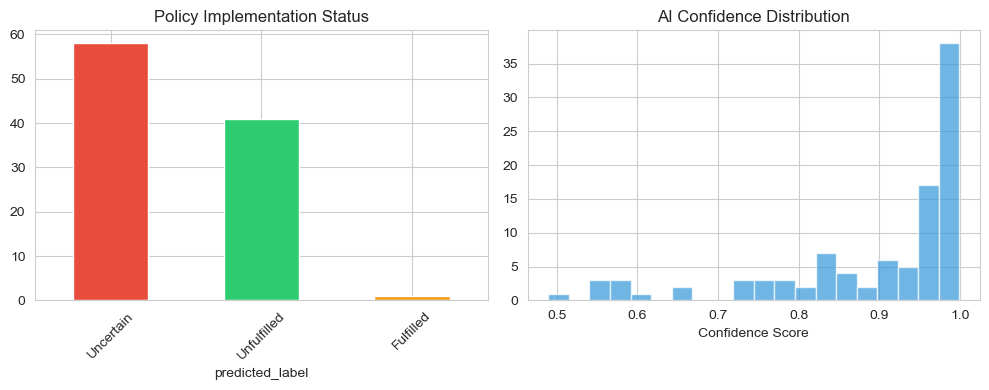

In [17]:
# Create quick visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
pairs_df['predicted_label'].value_counts().plot(kind='bar', color=['#e74c3c', '#2ecc71', '#f39c12'])
plt.title('Policy Implementation Status')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(pairs_df['confidence'], bins=20, alpha=0.7, color='#3498db')
plt.title('AI Confidence Distribution')
plt.xlabel('Confidence Score')

plt.tight_layout()
plt.show()